In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split

In [15]:
test_source = '/content/drive/MyDrive/Colab Notebooks/Kaggle /2/data/assignment_2_test.csv'
train_source = '/content/drive/MyDrive/Colab Notebooks/Kaggle /2/data/assignment_2_train.csv'

In [16]:
test_data = pd.read_csv(test_source)
train_data = pd.read_csv(train_source)

In [17]:
test_data.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,credit,299.0,87.0,116.0,NaN,aol.com,NaN,2.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,3.0,2.0,6.0,2.0,4.0,4.0,0.0,4.0,3.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,452.000000,2924.000000,2924.000000,0.0,412.0,0.0,412.0,206.0,412.0,412.0,452.0,2512.0,2512.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,debit,330.0,87.0,NaN,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,1.0,3059.949951,3059.949951,3059.949951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3059.949951,3059.949951,3059.949951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
target = train_data['isFraud']
train_no_target = train_data.drop(['isFraud'], axis = 1)

In [19]:
train_data.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 300.6+ MB


##      EDA - Exploration Data Analysis

In [21]:
test_data.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,1.000010e+05,100001.000000,1.000010e+05,100001.000000,100001.000000,98325.000000,99185.000000,98701.000000,88300.000000,88300.000000,39103.000000,4360.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,99732.000000,53475.000000,57535.000000,79300.00000,51368.000000,11065.000000,6062.000000,9458.000000,9458.000000,93964.000000,66962.000000,10316.000000,10716.000000,10299.000000,...,99732.000000,99732.000000,100001.000000,100001.000000,100001.000000,100001.0,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,99732.000000,99732.000000,99732.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000
mean,3.337000e+06,0.038040,8.696663e+06,140.674821,9882.200528,357.652672,153.271785,198.466672,289.507758,86.863941,104.271386,235.587615,8.279797,8.222968,0.003690,0.651513,6.056549,5.946601,0.244288,0.686413,4.790442,0.711613,6.016320,0.447686,29.593744,6.455335,94.306983,165.236971,29.161745,132.77517,43.627453,69.694442,39.559221,125.557385,0.544697,114.221649,137.867686,59.804963,19.829507,53.252646,...,0.043757,0.052230,0.183058,0.210938,0.192898,1.0,48.877726,241.794153,103.815527,12.446817,121.980028,4.701370,42.273046,24.150363,45.612901,30.718740,20.610689,90.901028,40.923873,15.612109,28.682812,20.397278,0.405669,1.282403,0.637437,0.035872,0.762622,0.206082,0.168881,0.242545,0.192944,81.733429,123.824365,91.572815,6.744021,36.245940,11.969737,47.597468,52.675413,48.497675
std,2.886795e+04,0.191293,7.603909e+05,240.272633,4867.290775,156.984512,11.512903,41.495035,101.589641,2.143002,342.377797,581.269021,35.161531,36.349635,0.159111,16.933688,27.014512,25.633511,2.223536,9.852489,16.840890,9.083298,26.370039,4.119370,101.050089,24.472343,158.798907,178.634878,64.847379,188.96681,92.424505,145.454726,97.147515,209.509607,0.325800,179.222515,181.842617,130.682134,71.340378,131.274497,...,0.262021,0.295744,0.420202,0.569056,0.458835,0.0,318.423256,1510.828700,549.612646,102.276379,354.206073,76.518535,171.184696,101.663324,169.630670,127.638746,196.938556,1380.593926,431.777948,197.011698,236.021642,210.136843,0.978676,3.545839,1.398336,0.201970,3.180813,0.876579,0.556401,0.739561,0.606917,715.898781,777.526194,718.203590,214.832591,269.734936,216.315923,597.985868,600.451426,598.024560
min,3.287000e+06,0.000000,7.415038e+06,0.251000,1004.000000,100.000000,100.000000,100.000000,104.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.312000e+06,0.000000,8.023328e+06,44.529000,6019.000000,206.000000,150.000000,166.000000,204.000000,87.000000,3.000000,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1

Проверим пропуски


In [22]:
test_data.isnull().sum().sort_values(ascending=False)

dist2            95641
D7               93939
V142             93276
V158             93276
V153             93276
                 ...  
V119                 0
V118                 0
V117                 0
V116                 0
TransactionID        0
Length: 394, dtype: int64

Для начала поработаем с данными. Создадим 3 группы данных: числовые, категориальные, сконкатенированные числовые и обработанные категориальные

In [23]:
# Разделим без обработки
x_train, x_valid = train_test_split(
    train_data, train_size=0.8, random_state = 1
    )

y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state = 1
    )

In [24]:
# Числовые данные
numerical_features = train_data.select_dtypes(include=[np.number])
numerical_targets = numerical_features['isFraud']
numerical_features = numerical_features.drop(['isFraud'], axis = 1)


# Выполним train_test_split числовых данных с суффиксом 1


x_train_1, x_valid_1 = train_test_split(
    numerical_features, train_size=0.8, random_state = 1
    )

y_train_1, y_valid_1 = train_test_split(
    numerical_targets, train_size=0.8, random_state = 1
    )

Проверяем

In [25]:
x_train_1.head(2)

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
5849,2992849,183461,50.00,7919,194.0,150.0,166.0,325.0,87.0,NaN,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,4.0,2.0,215.0,214.0,214.0,NaN,NaN,NaN,NaN,NaN,NaN,214.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113764,3100764,2218244,30.95,3109,390.0,150.0,224.0,498.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,6.0,1.0,72.0,72.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,NaN,NaN,NaN,72.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
x_train_1.shape, y_train_1.shape

((144000, 379), (144000,))

In [27]:
x_valid_1.shape, y_valid_1.shape

((36000, 379), (36000,))

In [28]:
# Категориальные (сделаем по остаточному принципу. Добавим только то, чего нет в датафреме с числовыми данными)
categorical_features = train_data.drop(numerical_features.columns, axis=1)
categorical_targets = categorical_features.isFraud

categorical_features  = categorical_features.drop(['isFraud'], axis=1)



In [29]:
# Добавим dammy переменные

categorical_features_dummy = pd.get_dummies(categorical_features)

# Сконкатенируем с числовыми данными и выполним разделение на валидационные и тренировочные данные

train_dummy = pd.concat([numerical_features, categorical_features_dummy])
target_dummy = pd.concat([numerical_targets, categorical_targets])
print(f'Размер сканкатенированных числовых данных и дамми категориальных данных - {train_dummy.shape}, Размер целевой переменной - {target_dummy.shape}')


x_train_2, x_valid_2 = train_test_split(
    train_dummy, train_size=0.8, random_state = 1
    )

y_train_2, y_valid_2 = train_test_split(
    target_dummy, train_size=0.8, random_state = 1
    )

Размер сканкатенированных числовых данных и дамми категориальных данных - (360000, 530), Размер целевой переменной - (360000,)


In [30]:
# Разделим категориальные признаки без объединения с числовыми
categorical_features = train_data.drop(numerical_features.columns, axis=1)
categorical_targets = categorical_features.isFraud

categorical_features  = categorical_features.drop(['isFraud'], axis=1)

for i in categorical_features:
  categorical_features[i] = categorical_features[i].astype('category')


x_train_3, x_valid_3 = train_test_split(
    categorical_features, train_size=0.8, random_state = 1
    )

y_train_3, y_valid_3 = train_test_split(
    categorical_targets, train_size=0.8, random_state = 1
    )

In [31]:
# Разделим ОБРАБОТАННЫЕ dummy категориальные признаки без объединения с числовыми

categorical_features_dummy = pd.get_dummies(categorical_features)


x_train_4, x_valid_4 = train_test_split(
    categorical_features_dummy, train_size=0.8, random_state = 1
    )

y_train_4, y_valid_4 = train_test_split(
    categorical_targets, train_size=0.8, random_state = 1
    )


#### Данные создали и обработали. Посмотрим результат на различных алгоритмах

## Задание 1: отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [75]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 5, # С глубиной деревьев = 4 результат хуже
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [76]:
dtrain = xgb.DMatrix(
    data=x_train_1, label=y_train_1
)
dvalid = xgb.DMatrix(
    data=x_valid_1, label=y_valid_1
)

In [79]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=10,
    early_stopping_rounds=150,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.655332	valid-auc:0.652694
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 150 rounds.
[9]	train-auc:0.791462	valid-auc:0.790311


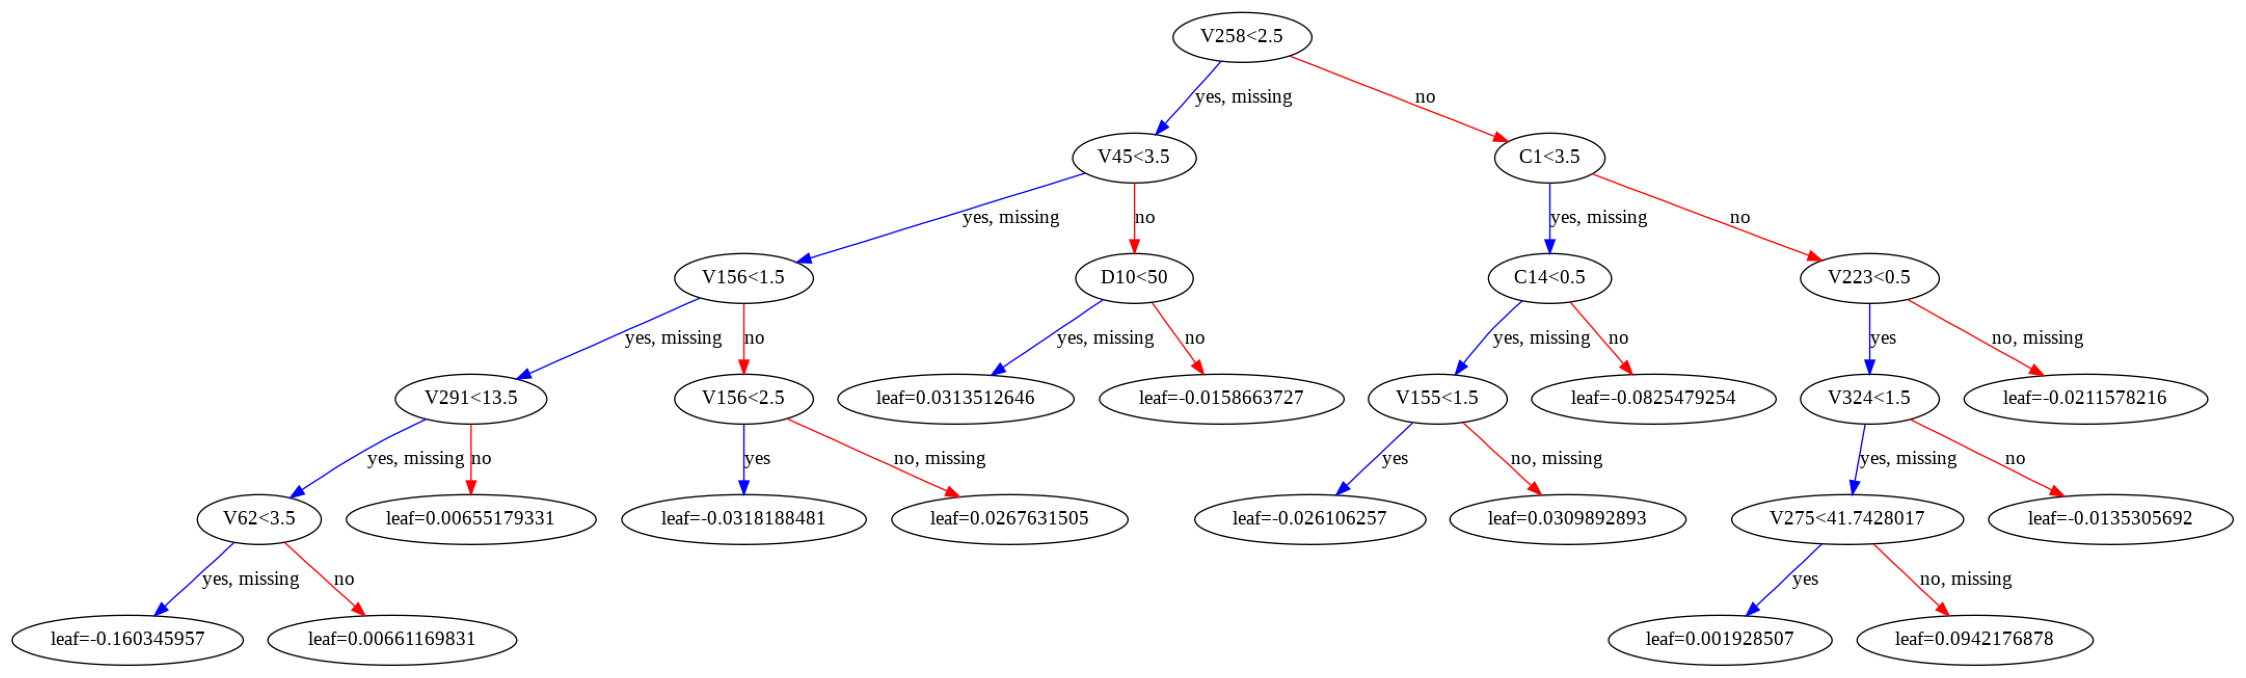

In [78]:
fig, axes = plt.subplots(1, 1, figsize=(40, 40))
xgb.plot_tree(model, num_trees=2, ax=axes)

И кроссвалидация

In [80]:
cv_result1 = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    early_stopping_rounds=25,
    verbose_eval=25,
    stratified=True,
    metrics="auc",
    maximize=True,
    shuffle=True,
    nfold=3
)

[0]	train-auc:0.629924+0.000555218	test-auc:0.625118+0.00514302
[25]	train-auc:0.84568+0.00149101	test-auc:0.841633+0.00359235
[50]	train-auc:0.886383+0.00327263	test-auc:0.879716+0.00468237
[75]	train-auc:0.89843+0.00290137	test-auc:0.888778+0.00526129
[99]	train-auc:0.904229+0.00297044	test-auc:0.892759+0.00515816


## Задание 2: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. (уже сделано) Выполнить задание 1.

Мы заранее создали категориальные данные с dummy переменными и разделили на валидационные и тренировочные данные (x_train_2). Применим их здесь

In [91]:
dtrain = xgb.DMatrix(
    data=x_train_2, label=y_train_2
)

dvalid = xgb.DMatrix(
    data=x_valid_2, label=y_valid_2
)

In [92]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=10,
    early_stopping_rounds=150,                      # Увеличим количество итераций
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.648424	valid-auc:0.643809
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 150 rounds.
[9]	train-auc:0.701247	valid-auc:0.689898


Если сравнивать результат с использованием только числовых данных, то результат после соединения данных стал хуже.

Посмотрим результат на кросс-валидации

In [93]:
cv_result2 = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    early_stopping_rounds=25,
    verbose_eval=25,
    stratified=True,
    metrics="auc",
    maximize=True,
    shuffle=True,
    nfold=3,
)

[0]	train-auc:0.567076+0.00319654	test-auc:0.565512+0.00435056
[25]	train-auc:0.786202+0.00573888	test-auc:0.783848+0.00644507
[50]	train-auc:0.834432+0.00135436	test-auc:0.829103+0.00380354
[75]	train-auc:0.845181+0.00176759	test-auc:0.837883+0.00257437
[99]	train-auc:0.849845+0.00196792	test-auc:0.841728+0.00258948


## Задание 4: для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [95]:
# Данные мы уже получили. Поэтому сразу применим модель
import lightgbm as lgb



In [96]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 200,
    "n_jobs": 6,
    "seed": 27
}

In [97]:
dtrain = lgb.Dataset(
    data=x_train_1, label=y_train_1
)
dvalid = lgb.Dataset(
    data=x_valid_1, label=y_valid_1
)

model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=200,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=10
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.833804	valid_1's auc: 0.830546
[20]	training's auc: 0.839163	valid_1's auc: 0.834809
[30]	training's auc: 0.866859	valid_1's auc: 0.86122
[40]	training's auc: 0.875628	valid_1's auc: 0.868807
[50]	training's auc: 0.879625	valid_1's auc: 0.871565
[60]	training's auc: 0.882876	valid_1's auc: 0.874801
[70]	training's auc: 0.884589	valid_1's auc: 0.876463
[80]	training's auc: 0.886281	valid_1's auc: 0.877537
[90]	training's auc: 0.888114	valid_1's auc: 0.878621
[100]	training's auc: 0.890189	valid_1's auc: 0.880224
[110]	training's auc: 0.892996	valid_1's auc: 0.882575
[120]	training's auc: 0.895754	valid_1's auc: 0.884363
[130]	training's auc: 0.897751	valid_1's auc: 0.885366
[140]	training's auc: 0.901759	valid_1's auc: 0.886509
[150]	training's auc: 0.903273	valid_1's auc: 0.887434
[160]	training's auc: 0.904668	valid_1's auc: 0.888608
[170]	training's auc: 0.906369	valid_1's auc: 0.889671
[180]	trainin

In [45]:
params["boosting_type"] = "goss"

model1 = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=200,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=10
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.833804	valid_1's auc: 0.830546
[20]	training's auc: 0.839163	valid_1's auc: 0.834809
[30]	training's auc: 0.866859	valid_1's auc: 0.86122
[40]	training's auc: 0.875628	valid_1's auc: 0.868807
[50]	training's auc: 0.879625	valid_1's auc: 0.871565
[60]	training's auc: 0.882876	valid_1's auc: 0.874801
[70]	training's auc: 0.884589	valid_1's auc: 0.876463
[80]	training's auc: 0.886281	valid_1's auc: 0.877537
[90]	training's auc: 0.888114	valid_1's auc: 0.878621
[100]	training's auc: 0.890189	valid_1's auc: 0.880224
[110]	training's auc: 0.893811	valid_1's auc: 0.883379
[120]	training's auc: 0.896557	valid_1's auc: 0.885342
[130]	training's auc: 0.898232	valid_1's auc: 0.887028
[140]	training's auc: 0.900899	valid_1's auc: 0.88858
[150]	training's auc: 0.903814	valid_1's auc: 0.889722
[160]	training's auc: 0.905388	valid_1's auc: 0.890745
[170]	training's auc: 0.907229	valid_1's auc: 0.89135
[180]	training'

In [98]:
cv_result3 = lgb.cv(
    params=params,
    train_set=dtrain,
    num_boost_round=200,
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=10,
    stratified=True,
    shuffle=True,
    nfold=5, 
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	cv_agg's auc: 0.829181 + 0.00963691
[20]	cv_agg's auc: 0.839534 + 0.0104883
[30]	cv_agg's auc: 0.859723 + 0.0141038
[40]	cv_agg's auc: 0.870641 + 0.00932152
[50]	cv_agg's auc: 0.874124 + 0.00852033
[60]	cv_agg's auc: 0.876266 + 0.00848991
[70]	cv_agg's auc: 0.877494 + 0.00849222
[80]	cv_agg's auc: 0.878954 + 0.00842845
[90]	cv_agg's auc: 0.880459 + 0.00794598
[100]	cv_agg's auc: 0.882227 + 0.00787554
[110]	cv_agg's auc: 0.885222 + 0.00762074
[120]	cv_agg's auc: 0.886623 + 0.00698358
[130]	cv_agg's auc: 0.888474 + 0.0070041
[140]	cv_agg's auc: 0.890956 + 0.00754694
[150]	cv_agg's auc: 0.89225 + 0.00723768
[160]	cv_agg's auc: 0.893579 + 0.00700746
[170]	cv_agg's auc: 0.894614 + 0.00655855
[180]	cv_agg's auc: 0.895873 + 0.00618503
[190]	cv_agg's auc: 0.897007 + 0.00612369
[200]	cv_agg's auc: 0.897983 + 0.00624249


## Задание 5: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

In [110]:
dtrain = lgb.Dataset(
    data=x_train_2, label=y_train_2
)
dvalid = lgb.Dataset(
    data=x_valid_2, label=y_valid_2
)

model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=200,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=10
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.78879	valid_1's auc: 0.778557
[20]	training's auc: 0.803375	valid_1's auc: 0.790709
[30]	training's auc: 0.820368	valid_1's auc: 0.807581
[40]	training's auc: 0.826026	valid_1's auc: 0.814078
[50]	training's auc: 0.829607	valid_1's auc: 0.817892
[60]	training's auc: 0.834624	valid_1's auc: 0.823202
[70]	training's auc: 0.839985	valid_1's auc: 0.829927
[80]	training's auc: 0.84262	valid_1's auc: 0.831437
[90]	training's auc: 0.843912	valid_1's auc: 0.831593
[100]	training's auc: 0.845729	valid_1's auc: 0.833481
[110]	training's auc: 0.84752	valid_1's auc: 0.835414
[120]	training's auc: 0.849599	valid_1's auc: 0.836986
[130]	training's auc: 0.851317	valid_1's auc: 0.838832
[140]	training's auc: 0.853018	valid_1's auc: 0.840713
[150]	training's auc: 0.854354	valid_1's auc: 0.842034
[160]	training's auc: 0.85574	valid_1's auc: 0.84371
[170]	training's auc: 0.857039	valid_1's auc: 0.844799
[180]	training's 

In [111]:
cv_result4 = lgb.cv(
    params=params,
    train_set=dtrain,
    num_boost_round=200,
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=10,
    stratified=True,
    shuffle=True,
    nfold=5, 
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	cv_agg's auc: 0.785477 + 0.00304258
[20]	cv_agg's auc: 0.80234 + 0.00310676
[30]	cv_agg's auc: 0.810348 + 0.00323396
[40]	cv_agg's auc: 0.81976 + 0.00230057
[50]	cv_agg's auc: 0.825665 + 0.00329653
[60]	cv_agg's auc: 0.829609 + 0.00391473
[70]	cv_agg's auc: 0.834408 + 0.00287611
[80]	cv_agg's auc: 0.836401 + 0.00290198
[90]	cv_agg's auc: 0.838502 + 0.00245
[100]	cv_agg's auc: 0.840363 + 0.00253386
[110]	cv_agg's auc: 0.84212 + 0.00264212
[120]	cv_agg's auc: 0.843628 + 0.00233879
[130]	cv_agg's auc: 0.845 + 0.00239982
[140]	cv_agg's auc: 0.846354 + 0.00232776
[150]	cv_agg's auc: 0.847486 + 0.0022467
[160]	cv_agg's auc: 0.848608 + 0.00227288
[170]	cv_agg's auc: 0.849597 + 0.00214344
[180]	cv_agg's auc: 0.850219 + 0.00217896
[190]	cv_agg's auc: 0.850742 + 0.00217714
[200]	cv_agg's auc: 0.851526 + 0.00221363


In [50]:
model4 = lgb.LGBMClassifier(**params)
model4.fit(
    X=x_train_2,
    y=y_train_2,
    eval_set=[(x_train_2, y_train_2), (x_valid_2, y_valid_2)],
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=10
)

Training until validation scores don't improve for 25 rounds.
[10]	training's auc: 0.78879	valid_1's auc: 0.778557
[20]	training's auc: 0.803375	valid_1's auc: 0.790709
[30]	training's auc: 0.820368	valid_1's auc: 0.807581
[40]	training's auc: 0.826026	valid_1's auc: 0.814078
[50]	training's auc: 0.829607	valid_1's auc: 0.817892
[60]	training's auc: 0.834624	valid_1's auc: 0.823202
[70]	training's auc: 0.839985	valid_1's auc: 0.829927
[80]	training's auc: 0.84262	valid_1's auc: 0.831437
[90]	training's auc: 0.843912	valid_1's auc: 0.831593
[100]	training's auc: 0.845729	valid_1's auc: 0.833481
[110]	training's auc: 0.847878	valid_1's auc: 0.835897
[120]	training's auc: 0.849639	valid_1's auc: 0.837519
[130]	training's auc: 0.851335	valid_1's auc: 0.839071
[140]	training's auc: 0.853079	valid_1's auc: 0.840837
[150]	training's auc: 0.85447	valid_1's auc: 0.84222
[160]	training's auc: 0.855715	valid_1's auc: 0.843803
[170]	training's auc: 0.857088	valid_1's auc: 0.844922
[180]	training's

LGBMClassifier(boosting_type='goss', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=200, n_jobs=6, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, seed=27, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

## Задание 6: обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.


In [113]:
params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 200,
    "n_jobs": 6,
    "seed": 27
}


In [114]:
train_5 = train_data.copy()
target_5 = train_5['isFraud']
train_5 = train_5.drop(['isFraud'], axis = 1)


In [115]:
for c in categorical_features.columns:
    train_5[c] = train_5[c].astype('category')

In [116]:
x_train, x_valid = train_test_split(
    train_5, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target_5, train_size=0.8, random_state=1
)

In [117]:
dtrain = lgb.Dataset(
    data=x_train, label=y_train
)
dvalid = lgb.Dataset(
    data=x_valid, label=y_valid
)

In [56]:
model_lgbm_cat = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature=[i for i in categorical_features.columns],
    early_stopping_rounds=50,
    verbose_eval=50
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'card4', 'card6']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.882461	valid_1's auc: 0.874022
[100]	training's auc: 0.901365	valid_1's auc: 0.888637
[150]	training's auc: 0.911345	valid_1's auc: 0.898212
[200]	training's auc: 0.919505	valid_1's auc: 0.904138
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.919505	valid_1's auc: 0.904138


In [118]:
cv_result5 = lgb.cv(
    params=params,
    train_set=dtrain,
    num_boost_round=200,
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=10,
    stratified=True,
    shuffle=True,
    nfold=5, 
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	cv_agg's auc: 0.829194 + 0.00992332
[20]	cv_agg's auc: 0.839647 + 0.0104783
[30]	cv_agg's auc: 0.864592 + 0.0114831
[40]	cv_agg's auc: 0.871451 + 0.0104742
[50]	cv_agg's auc: 0.876172 + 0.00892135
[60]	cv_agg's auc: 0.879471 + 0.00852033
[70]	cv_agg's auc: 0.883522 + 0.00694649
[80]	cv_agg's auc: 0.886702 + 0.00766827
[90]	cv_agg's auc: 0.889288 + 0.00742568
[100]	cv_agg's auc: 0.891459 + 0.00766624
[110]	cv_agg's auc: 0.89345 + 0.0073726
[120]	cv_agg's auc: 0.895267 + 0.00748812
[130]	cv_agg's auc: 0.896873 + 0.00734043
[140]	cv_agg's auc: 0.898225 + 0.00731264
[150]	cv_agg's auc: 0.899917 + 0.00728508
[160]	cv_agg's auc: 0.901285 + 0.00710527
[170]	cv_agg's auc: 0.902661 + 0.00683435
[180]	cv_agg's auc: 0.903815 + 0.00665233
[190]	cv_agg's auc: 0.90471 + 0.00649445
[200]	cv_agg's auc: 0.9058 + 0.00657


#### Результат был - [200]	cv_agg's auc: 0.851526 + 0.00221363
Стал - [200]	cv_agg's auc: 0.9058 + 0.00657

## Задание 7: для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [57]:
!pip install catboost

     |████████████████████████████████| 65.7MB 133kB/s 


In [122]:
import catboost as cb

In [123]:
cb_params = {
    "n_estimators": 200,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [124]:
model_catbost7 = cb.CatBoostClassifier(**cb_params)
model_catbost7.fit(x_train_1, y_train_1, eval_set=[(x_train_1, y_train_1), (x_valid_1, y_valid_1)])

0:	test: 0.6536408	test1: 0.6473652	best: 0.6473652 (0)	total: 256ms	remaining: 51s
10:	test: 0.8007710	test1: 0.7847468	best: 0.7847468 (10)	total: 2.14s	remaining: 36.8s
20:	test: 0.8309159	test1: 0.8158329	best: 0.8158329 (20)	total: 4.14s	remaining: 35.3s
30:	test: 0.8530706	test1: 0.8468549	best: 0.8468549 (30)	total: 6.13s	remaining: 33.5s
40:	test: 0.8561253	test1: 0.8513619	best: 0.8513619 (40)	total: 8.18s	remaining: 31.7s
50:	test: 0.8576422	test1: 0.8518286	best: 0.8518286 (50)	total: 10.3s	remaining: 30.2s
60:	test: 0.8586473	test1: 0.8536193	best: 0.8546607 (55)	total: 12.4s	remaining: 28.1s
70:	test: 0.8595522	test1: 0.8549355	best: 0.8549741 (69)	total: 14.5s	remaining: 26.3s
80:	test: 0.8612718	test1: 0.8565497	best: 0.8565497 (80)	total: 16.6s	remaining: 24.3s
90:	test: 0.8639606	test1: 0.8584526	best: 0.8584871 (89)	total: 18.6s	remaining: 22.2s
100:	test: 0.8650118	test1: 0.8596649	best: 0.8598161 (99)	total: 20.7s	remaining: 20.2s
110:	test: 0.8690690	test1: 0.86211

In [142]:
cv_result7 = cb.cv(
    cb.Pool(x_train_1, y_train_1),
    cb_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6543966	best: 0.6543966 (0)	total: 760ms	remaining: 2m 31s
10:	test: 0.8012026	best: 0.8024100 (9)	total: 5.58s	remaining: 1m 35s
20:	test: 0.8221749	best: 0.8221749 (20)	total: 10.5s	remaining: 1m 29s
30:	test: 0.8385501	best: 0.8385501 (30)	total: 15.6s	remaining: 1m 24s
40:	test: 0.8436105	best: 0.8436105 (40)	total: 20.6s	remaining: 1m 20s
50:	test: 0.8487195	best: 0.8487195 (50)	total: 25.9s	remaining: 1m 15s
60:	test: 0.8516332	best: 0.8516332 (60)	total: 31.1s	remaining: 1m 10s
70:	test: 0.8545297	best: 0.8545297 (70)	total: 36.3s	remaining: 1m 5s
80:	test: 0.8578574	best: 0.8578574 (80)	total: 41.7s	remaining: 1m 1s
90:	test: 0.8610240	best: 0.8610240 (90)	total: 46.9s	remaining: 56.1s
100:	test: 0.8614728	best: 0.8614728 (100)	total: 51.9s	remaining: 50.9s
110:	test: 0.8621976	best: 0.8621976 (110)	total: 57s	remaining: 45.7s
120:	test: 0.8640378	best: 0.8640523 (119)	total: 1m 2s	remaining: 40.7s
130:	test: 0.8657912	best: 0.8657912 (130)	total: 1m 7s	remaining: 35

## Задание 8: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.

In [133]:
model_catbost8 = cb.CatBoostClassifier(**cb_params)
model_catbost8.fit(x_train_2, y_train_2, eval_set=[(x_train_2, y_train_2), (x_valid_2, y_valid_2)])

0:	test: 0.5904320	test1: 0.5897128	best: 0.5897128 (0)	total: 381ms	remaining: 1m 15s
10:	test: 0.6682716	test1: 0.6529311	best: 0.6534842 (9)	total: 3.73s	remaining: 1m 4s
20:	test: 0.7579825	test1: 0.7475799	best: 0.7477504 (19)	total: 7.1s	remaining: 1m
30:	test: 0.7721620	test1: 0.7634308	best: 0.7634308 (30)	total: 10.6s	remaining: 57.8s
40:	test: 0.7777963	test1: 0.7739822	best: 0.7739822 (40)	total: 14.3s	remaining: 55.3s
50:	test: 0.7868988	test1: 0.7820803	best: 0.7833116 (47)	total: 18.3s	remaining: 53.4s
60:	test: 0.7879189	test1: 0.7832865	best: 0.7836551 (59)	total: 22.2s	remaining: 50.5s
70:	test: 0.7974189	test1: 0.7938692	best: 0.7938692 (70)	total: 26s	remaining: 47.3s
80:	test: 0.8006411	test1: 0.7963879	best: 0.7963879 (80)	total: 30s	remaining: 44.1s
90:	test: 0.8022208	test1: 0.7980536	best: 0.7983510 (86)	total: 33.9s	remaining: 40.6s
100:	test: 0.8054956	test1: 0.8011841	best: 0.8011841 (100)	total: 38.1s	remaining: 37.4s
110:	test: 0.8072864	test1: 0.8029308	be

In [144]:
cv_result8 = cb.cv(
    cb.Pool(x_train_2, y_train_2),
    cb_params,
    plot=False
)

0:	test: 0.6348795	best: 0.6348795 (0)	total: 2.45s	remaining: 8m 7s
10:	test: 0.6975140	best: 0.6975140 (10)	total: 10.1s	remaining: 2m 53s
20:	test: 0.7467770	best: 0.7467770 (20)	total: 17.9s	remaining: 2m 32s
30:	test: 0.7588823	best: 0.7588823 (30)	total: 25.6s	remaining: 2m 19s
40:	test: 0.7726198	best: 0.7726198 (40)	total: 33.8s	remaining: 2m 11s
50:	test: 0.7822727	best: 0.7826586 (49)	total: 42.1s	remaining: 2m 3s
60:	test: 0.7855499	best: 0.7855499 (60)	total: 50.5s	remaining: 1m 54s
70:	test: 0.7857657	best: 0.7862444 (68)	total: 58.6s	remaining: 1m 46s
80:	test: 0.7916249	best: 0.7916249 (80)	total: 1m 7s	remaining: 1m 38s
90:	test: 0.7943549	best: 0.7943549 (90)	total: 1m 15s	remaining: 1m 30s
100:	test: 0.7999638	best: 0.7999638 (100)	total: 1m 23s	remaining: 1m 22s
110:	test: 0.8037419	best: 0.8037419 (110)	total: 1m 32s	remaining: 1m 14s
120:	test: 0.8047148	best: 0.8047578 (118)	total: 1m 40s	remaining: 1m 5s
130:	test: 0.8061464	best: 0.8061464 (130)	total: 1m 48s	re

## Задание 9: обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.



In [145]:
for i in categorical_features.columns:
    train_5[i] = train_5[i].astype('str')

In [146]:
x_train, x_valid = train_test_split(
    train_5, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target_5, train_size=0.8, random_state=1
)

In [147]:
train_9 = cb.Pool(x_train, y_train, cat_features = categorical_features)
valid_9 = cb.Pool(x_valid, y_valid, cat_features = categorical_features)

In [64]:
model_catbost9 = cb.CatBoostClassifier(**cb_params)
model_catbost9.fit(train_9, eval_set=valid_9)

0:	test: 0.6090049	best: 0.6090049 (0)	total: 762ms	remaining: 2m 31s
10:	test: 0.7884374	best: 0.7891365 (9)	total: 7.7s	remaining: 2m 12s
20:	test: 0.8189401	best: 0.8189401 (20)	total: 14.7s	remaining: 2m 5s
30:	test: 0.8375294	best: 0.8378582 (27)	total: 21.5s	remaining: 1m 56s
40:	test: 0.8456887	best: 0.8456887 (40)	total: 28.6s	remaining: 1m 51s
50:	test: 0.8493960	best: 0.8493960 (50)	total: 35.7s	remaining: 1m 44s
60:	test: 0.8519462	best: 0.8519494 (59)	total: 42.9s	remaining: 1m 37s
70:	test: 0.8559554	best: 0.8561351 (69)	total: 50.5s	remaining: 1m 31s
80:	test: 0.8610777	best: 0.8610777 (80)	total: 57.8s	remaining: 1m 24s
90:	test: 0.8617064	best: 0.8617064 (90)	total: 1m 5s	remaining: 1m 17s
100:	test: 0.8632662	best: 0.8632662 (100)	total: 1m 12s	remaining: 1m 10s
110:	test: 0.8654217	best: 0.8654217 (110)	total: 1m 19s	remaining: 1m 3s
120:	test: 0.8674450	best: 0.8674450 (120)	total: 1m 26s	remaining: 56.6s
130:	test: 0.8689062	best: 0.8689062 (130)	total: 1m 34s	remai

In [148]:
cv_result9 = cv(train_9,
            cb_params,
            fold_count=2, 
            plot="False")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6792413	best: 0.6792413 (0)	total: 1.47s	remaining: 4m 53s
10:	test: 0.7877028	best: 0.7877028 (10)	total: 12.3s	remaining: 3m 31s
20:	test: 0.8248626	best: 0.8248626 (20)	total: 23.1s	remaining: 3m 16s
30:	test: 0.8398841	best: 0.8398841 (30)	total: 33.9s	remaining: 3m 4s
40:	test: 0.8472714	best: 0.8472714 (40)	total: 45.1s	remaining: 2m 54s
50:	test: 0.8504855	best: 0.8504855 (50)	total: 56.4s	remaining: 2m 44s
60:	test: 0.8526049	best: 0.8526049 (60)	total: 1m 7s	remaining: 2m 32s
70:	test: 0.8536989	best: 0.8536989 (70)	total: 1m 18s	remaining: 2m 21s
80:	test: 0.8575900	best: 0.8575900 (80)	total: 1m 29s	remaining: 2m 11s
90:	test: 0.8608026	best: 0.8608026 (90)	total: 1m 40s	remaining: 2m
100:	test: 0.8624334	best: 0.8624334 (100)	total: 1m 51s	remaining: 1m 49s
110:	test: 0.8634190	best: 0.8634190 (110)	total: 2m 2s	remaining: 1m 38s
120:	test: 0.8648041	best: 0.8648041 (120)	total: 2m 13s	remaining: 1m 27s
130:	test: 0.8656463	best: 0.8656463 (130)	total: 2m 24s	rem

Результат после обработки категориальных признаком catboost лучше, решение после применения dammy переменных.

##Задание 10: построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

In [152]:
cv_result7["test-AUC-mean"]


0      0.654397
1      0.719378
2      0.735371
3      0.757711
4      0.757910
         ...   
195    0.874591
196    0.874614
197    0.874707
198    0.874844
199    0.874902
Name: test-AUC-mean, Length: 200, dtype: float64

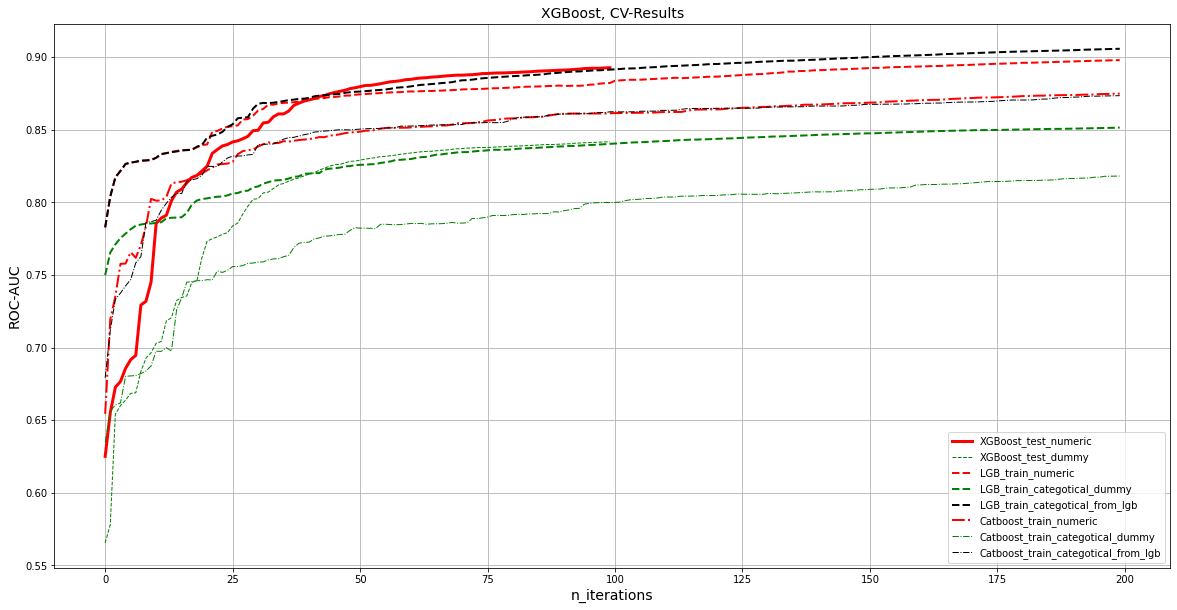

In [167]:
fig = plt.figure(figsize=(20, 10))
# plt.plot(cv_result1["train-auc-mean"], color="red", linewidth=3, label="XGBoost_train_numeric")
plt.plot(cv_result1["test-auc-mean"], color="red", linewidth=3, label="XGBoost_test_numeric")
plt.plot(cv_result2["test-auc-mean"], color="green", linestyle = '--', linewidth=1, label="XGBoost_test_dummy")



plt.plot(cv_result3["auc-mean"], color="red", linewidth=2, linestyle = '--', label="LGB_train_numeric")
plt.plot(cv_result4["auc-mean"], color="green", linewidth=2, linestyle = '--',label="LGB_train_categotical_dummy")
plt.plot(cv_result5["auc-mean"], color="black", linewidth=2, linestyle = '--', label="LGB_train_categotical_from_lgb")


plt.plot(cv_result7["test-AUC-mean"], color="red", linewidth=2, linestyle = '-.', label="Catboost_train_numeric")
plt.plot(cv_result8["test-AUC-mean"], color="green", linewidth=1, linestyle = '-.', label="Catboost_train_categotical_dummy")
plt.plot(cv_result9["test-AUC-mean"], color="black", linewidth=1, linestyle = '-.', label="Catboost_train_categotical_from_lgb")



# plt.fill_between(
#     x=cv_result.index,
#     y1=cv_result1["train-auc-mean"] - cv_result1["train-auc-std"],
#     y2=cv_result1["train-auc-mean"] + cv_result1["train-auc-std"],
#     alpha=0.25, color="blue"
# )
# plt.fill_between(
#     x=cv_result.index,
#     y1=cv_result1["test-auc-mean"] - cv_result1["test-auc-std"],
#     y2=cv_result1["test-auc-mean"] + cv_result1["test-auc-std"],
#     alpha=0.25, color="orange"
# )
plt.title("XGBoost, CV-Results", size=14)
plt.xlabel("n_iterations", size=14)
plt.ylabel("ROC-AUC", size=14)
plt.legend(loc="lower right")
plt.grid()
plt.show()

Судя по графику (если нигде не ошибся), меньше количество итераций для обучения нужно XGBoost на числовых данных для достижения результата близкого к 90, но с увеличением итераций, результат становится лучше у LightGBM с обработкой им же категориальных данных. Возможно с увеличением итераций у XGBoost так же результат был бы выше, но учитывая более высокую скорость обучения, LightGBM по моим данным более предпочтителен.